# MIDI Self-Similarity Matrices


In [2]:
import os
import pretty_midi
from midi_player import MIDIPlayer
from midi_player.stylers import dark

midi_file = os.path.join("data", "toy.mid")
midi_data = pretty_midi.PrettyMIDI(midi_file)

MIDIPlayer(midi_file, 300, styler=dark)

In [3]:
import soundfile as sf

midi_audio = midi_data.synthesize()
sf.write(os.path.join("outputs", "toy.wav"), midi_audio, 44100)

## Piano Roll SSMs

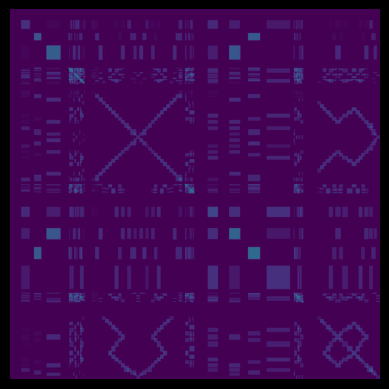

In [4]:
import numpy as np
from matplotlib import pyplot as plt

plt.style.use("dark_background")

piano_roll = midi_data.get_piano_roll()

ssm_midi = np.dot(np.transpose(piano_roll), piano_roll)
ssm_midi /= ssm_midi.max()

plt.imshow(ssm_midi)
plt.axis("off")
plt.show()

### Generate SSMs, novelties, and boundaries

In [5]:
import ssm_utils

filter_lens = [1, 100, 500, 1000]
downsamples = [5, 10, 100, 200]
ssms = []
novs = []
bnds = []

for fl in filter_lens:
    ssm_row = []
    nov_row = []
    bnd_row = []

    for ds in downsamples:
        sssm, n_smoothed = ssm_utils.gen_ssm_and_novelty(
            piano_roll, filter_length=fl, down_sampling=ds
        )
        boundary = ssm_utils.get_boundaries(
            n_smoothed, np.array(range(n_smoothed.shape[0]))
        )

        ssm_row.append(sssm)
        nov_row.append(n_smoothed)
        bnd_row.append(boundary)

    ssms.append(ssm_row)
    novs.append(nov_row)
    bnds.append(bnd_row)

/home/finlay/ssm/ssm_utils.py:54: RuntimeWarning: invalid value encountered in scalar divide
  peak_to_mean_v[nu] = data[nu] / local_mean


### Experiments with peak finder

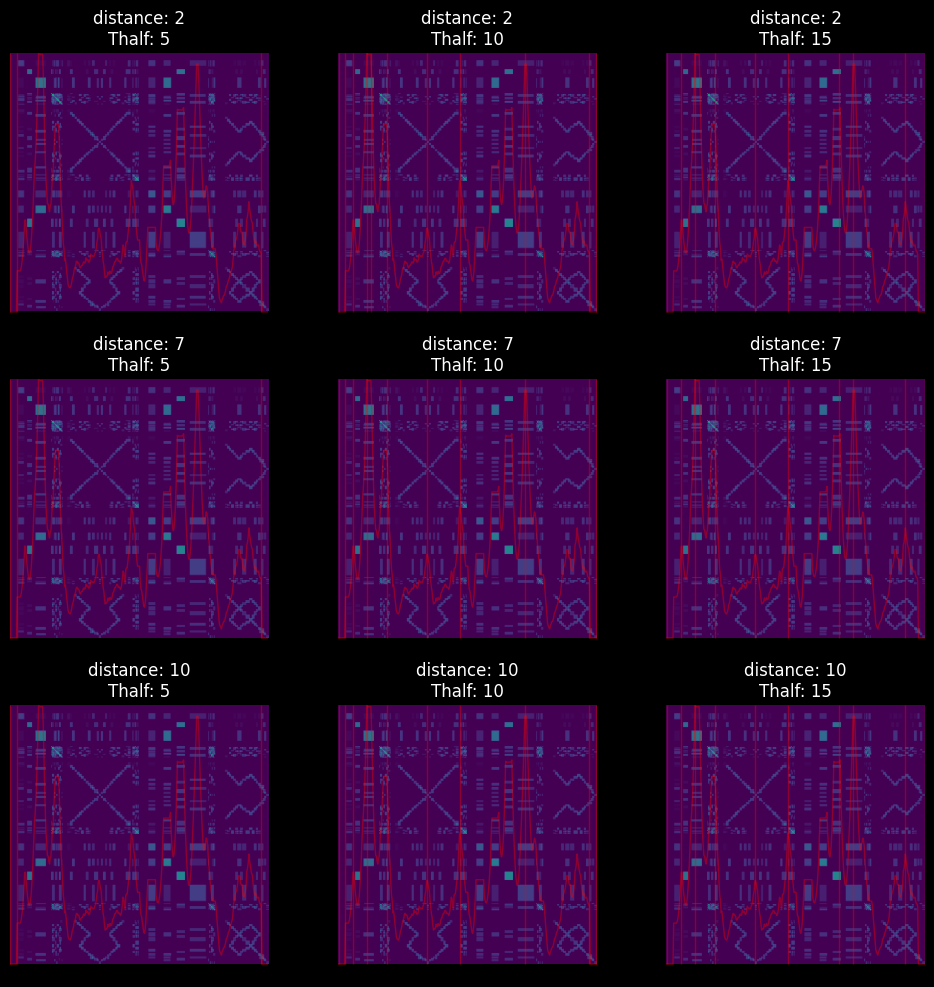

In [6]:
distances = [2, 7, 10]
Thalfs = [5, 10, 15]
ssm_test = ssms[0][1]
nov_test = novs[0][1]

fig_peak, axs_peak = plt.subplots(3, 3, figsize=(12, 12))

for i, row in enumerate(axs_peak):
    for j, ax in enumerate(row):
        boundary = ssm_utils.get_boundaries(
            nov_test,
            np.array(range(nov_test.shape[0])),
            {"Thalf": Thalfs[j], "tau": 1.35, "distance": distances[i]},
        )
        ax.imshow(ssm_test / ssm_test.max())
        ax.plot(
            (1 - nov_test / nov_test.max()) * ssm_test.shape[0],
            "r",
            linewidth=1,
            alpha=0.4,
        )
        ax.vlines(
            boundary[0], ax.dataLim.y0, ax.dataLim.y1, "r", linewidth=1, alpha=0.4
        )
        ax.axis("off")
        ax.set_title(f"distance: {distances[i]}\nThalf: {Thalfs[j]}")

plt.show()

### Plot

/tmp/ipykernel_409689/2760780665.py:9: RuntimeWarning: invalid value encountered in divide
  (1 - novs[i][j] / novs[i][j].max()) * ssms[i][j].shape[0],


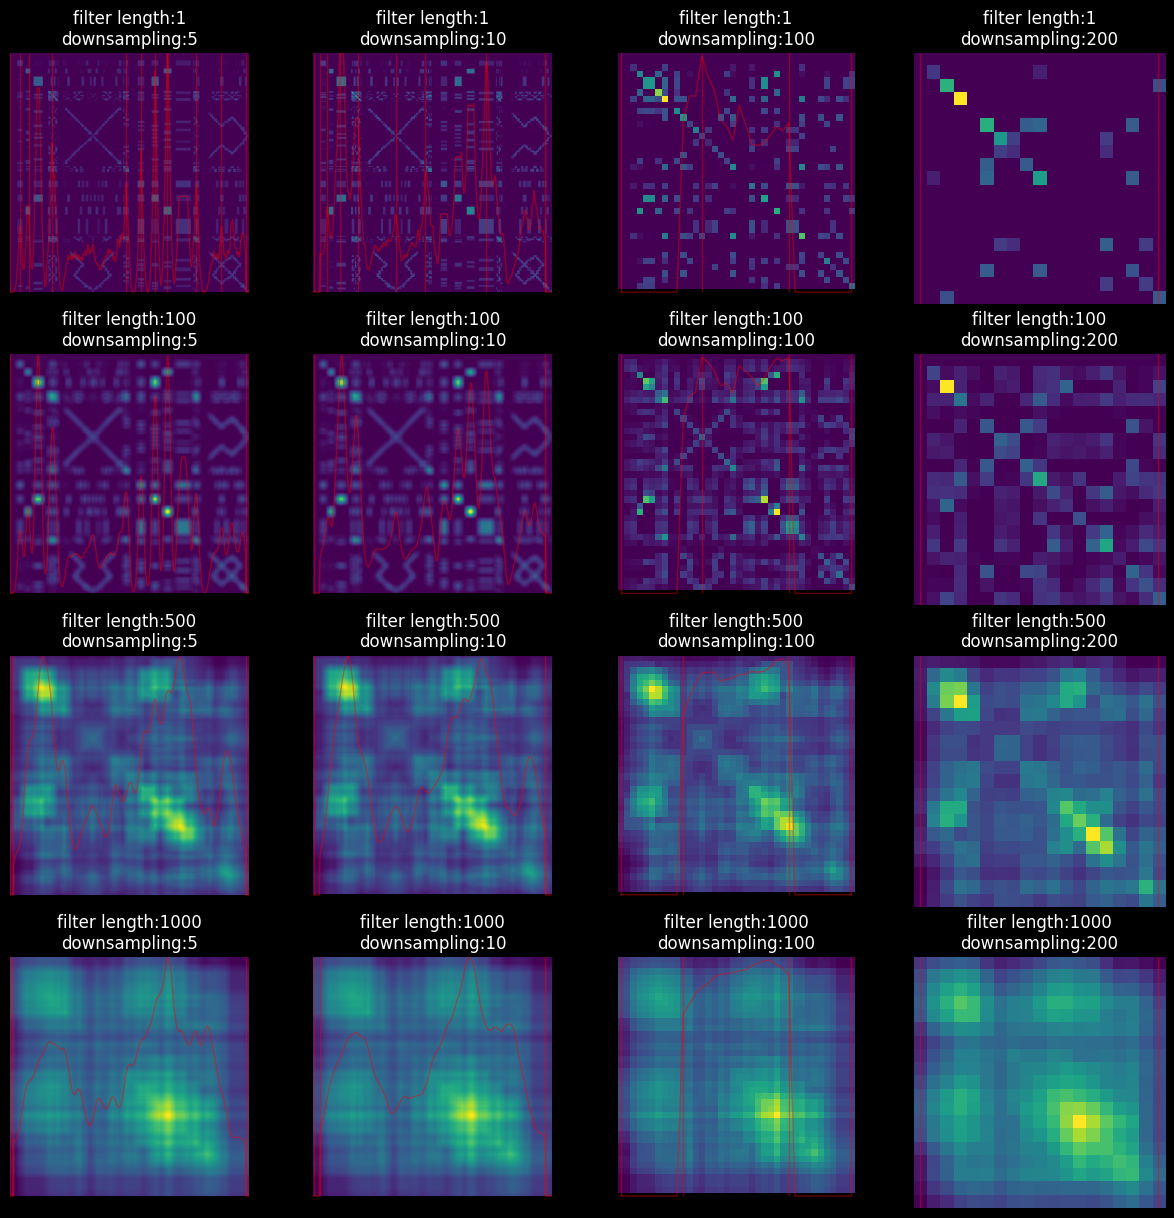

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# fig.suptitle("MIDI SSMs (fl=filter length, ds=downsample)")

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.imshow(ssms[i][j] / ssms[i][j].max())  # ssm
        ax.plot(  # novelty curve
            (1 - novs[i][j] / novs[i][j].max()) * ssms[i][j].shape[0],
            "r",
            linewidth=1,
            alpha=0.4,
        )
        ax.vlines(  # chunk bounds
            bnds[i][j][0], ax.dataLim.y0, ax.dataLim.y1, "r", linewidth=1, alpha=0.4
        )
        ax.axis("off")
        ax.set_title(f"filter length:{filter_lens[i]}\ndownsampling:{downsamples[j]}")

plt.show()

## Chroma SSMs

/home/finlay/ssm/ssm_utils.py:54: RuntimeWarning: invalid value encountered in scalar divide
  peak_to_mean_v[nu] = data[nu] / local_mean


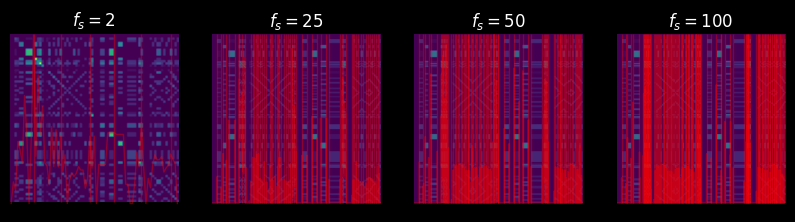

In [23]:
fss = [2, 25, 50, 100]
fig, axs = plt.subplots(1, len(fss), figsize=(10, 16))

for i, fs in enumerate(fss):
    chrom = midi_data.get_chroma(fs)
    ssm_chrom = np.dot(np.transpose(chrom), chrom)
    novelty_curve = ssm_utils.compute_novelty_ssm(ssm_chrom, L=1, exclude=True)
    boundary = ssm_utils.get_boundaries(
        novelty_curve, np.array(range(0, chrom.shape[1]))
    )

    # plot
    axs[i].imshow(ssm_chrom / ssm_chrom.max())
    axs[i].vlines(
        boundary[1], axs[i].dataLim.y0, axs[i].dataLim.y1, "r", linewidth=1, alpha=0.4
    )
    axs[i].plot(
        (1 - novelty_curve / novelty_curve.max()) * ssm_chrom.shape[0],
        "r",
        linewidth=1,
        alpha=0.4,
    )
    axs[i].set_title(rf"$f_s={fs}$")
    axs[i].axis("off")

# plt.imshow(ssm_chrom)
# plt.axis("off")
plt.show()

In [26]:
chrom = midi_data.get_chroma(2)
ssm_chrom = np.dot(np.transpose(chrom), chrom)
novelty_curve = ssm_utils.compute_novelty_ssm(ssm_chrom, L=1, exclude=True)
boundary = ssm_utils.get_boundaries(
    novelty_curve,
    np.array(range(0, chrom.shape[1])),
    {"Thalf": 10, "tau": 1.35, "distance": 7},
)

# plot
plt.imshow(chrom)
plt.vlines(
    boundary[1], axs[i].dataLim.y0, axs[i].dataLim.y1, "r", linewidth=1, alpha=0.4
)
plt.axis("off")
plt.plot()

[]

In [22]:
boundary[1]

array([10, 22, 35, 46, 58, 71])

## Pitch Histogram SSMs?

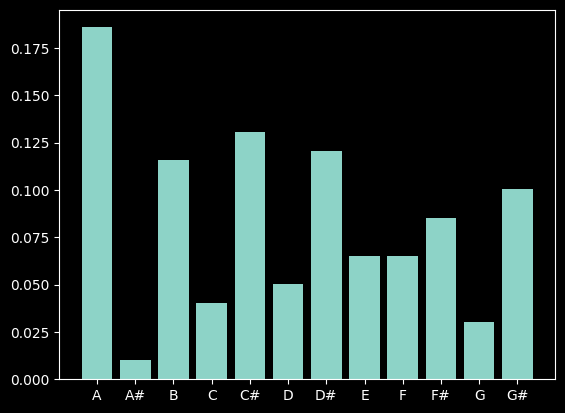

In [10]:
pch = midi_data.get_pitch_class_histogram()
# pct = midi_data.get_pitch_class_transition_matrix()
bins = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
plt.bar(bins, pch)
plt.show()